# Collaborative Filtering Pipeline


## Functions used in this pipeline


In [231]:
def create_matrix(df, user, item, rating):
  import numpy as np
  from scipy.sparse import csr_matrix
  
  U = df[user].nunique()  # Number of users for the matrix
  I = df[item].nunique()  # Number of items for the matrix
  
  # Map user and movie IDs to matrix indices
  user_mapper = dict(zip(np.unique(df[user]), list(range(U))))
  item_mapper = dict(zip(np.unique(df[item]), list(range(I))))
  
  # Map matrix indices back to IDs
  user_inv_mapper = dict(zip(list(range(U)), np.unique(df[user])))
  item_inv_mapper = dict(zip(list(range(I)), np.unique(df[item])))
  
  # Create a list of index values for the csr_matrix for users and movies
  user_index = [user_mapper[i] for i in df[user]]
  item_index = [item_mapper[i] for i in df[item]]
  
  # Build the final matrix which will look like: (movieId, userId) rating
  X = csr_matrix((df[rating], (item_index, user_index)), shape=(I, U))
  
  return X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper

In [232]:
def recommend(itemId, X, item_mapper, item_inv_mapper, k=10, metric='cosine', messages=True):
  from sklearn.neighbors import NearestNeighbors
  import numpy as np

  rec_ids = []
  rec_distances = []

    # Handle unknown item
  if itemId not in item_mapper:
    return ['no_rec'] * k, [np.nan] * k

  item = item_mapper[itemId]
  item_vector = X[item]

  knn = NearestNeighbors(n_neighbors=min(k + 1, X.shape[0]), algorithm="brute", metric=metric).fit(X)
  distances, indices = knn.kneighbors(item_vector.reshape(1, -1), return_distance=True)

  indices = indices[0]
  distances = distances[0]

  for idx, dist in zip(indices, distances):
    rec_item_id = item_inv_mapper[idx]
    if rec_item_id != itemId and rec_item_id not in rec_ids:
      rec_ids.append(rec_item_id)
      rec_distances.append(dist)
    if len(rec_ids) == k:
      break

    # Pad if fewer than k
  while len(rec_ids) < k:
    rec_ids.append('no_rec')
    rec_distances.append(np.nan)

  if messages:
    print(f"List of recommended item indices:\n{indices}\n")
    print(f"List of recommended item IDs:\n{rec_ids}\n")
    print(f"List of recommended item similarity to selected item:\n{rec_distances}\n")

  return rec_ids, rec_distances


## Import Data:


In [233]:
import os
import pyodbc
import pandas as pd
from dotenv import load_dotenv

# Load env vars
load_dotenv()

server = os.getenv("AZURE_SQL_SERVER")
database = os.getenv("AZURE_SQL_DATABASE")
username = os.getenv("AZURE_SQL_USERNAME")
password = os.getenv("AZURE_SQL_PASSWORD")

print("AZURE_SQL_USERNAME loaded:", bool(os.getenv("AZURE_SQL_USERNAME")))
print("AZURE_SQL_USERNAME loaded:", bool(os.getenv("AZURE_SQL_PASSWORD")))
print("AZURE_SQL_USERNAME loaded:", bool(os.getenv("AZURE_SQL_SERVER")))
print("AZURE_SQL_USERNAME loaded:", bool(os.getenv("AZURE_SQL_DATABASE")))

# Build connection string
connection_string = f"""
    DRIVER={{ODBC Driver 17 for SQL Server}};
    SERVER={server},1433;
    DATABASE={database};
    UID={username};
    PWD={password};
    Encrypt=yes;
    TrustServerCertificate=no;
    Connection Timeout=30;
"""

# Connect to SQL Server
conn = pyodbc.connect(connection_string)

# Query to fetch movie data
df_movies = pd.read_sql("SELECT * FROM movies_titles", conn)
df_users = pd.read_sql("SELECT * FROM movies_users", conn)
df_triple = pd.read_sql("SELECT * FROM movies_ratings", conn)

# Close connection
conn.close()

# Display the data
display(df_movies.head())
display(df_users.head())
display(df_triple.head())


C:\Users\Seank\AppData\Local\Temp\ipykernel_30364\1413149548.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_movies = pd.read_sql("SELECT * FROM movies_titles", conn)
C:\Users\Seank\AppData\Local\Temp\ipykernel_30364\1413149548.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_users = pd.read_sql("SELECT * FROM movies_users", conn)
C:\Users\Seank\AppData\Local\Temp\ipykernel_30364\1413149548.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_triple = pd.read_sql("SELECT * FROM movies_ratings", conn)


,show_id,type,title,director,cast,country,release_year,rating,duration,description,...,Language TV Shows,Musicals,Nature TV,Reality TV,Spirituality,TV Action,TV Comedies,TV Dramas,Talk Shows TV Comedies,Thrillers
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,"Michael Hilow, Ana Hoffman, Dick Johnson, Kirs...",United States,2021,PG-13,90 min,As her father nears the end of his life filmma...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,s2,TV Show,Blood & Water,None,Ama Qamata Khosi Ngema Gail Mabalane Thabang M...,South Africa,2021,TV-MA,2 Seasons,After crossing paths at a party a Cape Town te...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,s3,TV Show,Ganglands,Julien Leclercq,Sami Bouajila Tracy Gotoas Samuel Jouy Nabiha ...,None,2021,TV-MA,1 Season,To protect his family from a powerful drug lor...,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,s4,TV Show,Jailbirds New Orleans,None,None,None,2021,TV-MA,1 Season,Feuds flirtations and toilet talk go down amon...,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,s5,TV Show,Kota Factory,None,Mayur More Jitendra Kumar Ranjan Raj Alam Khan...,India,2021,TV-MA,2 Seasons,In a city of coaching centers known to train I...,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,user_id,name,phone,email,age,gender,Netflix,Amazon Prime,Disney+,Paramount+,Max,Hulu,Apple TV+,Peacock,city,state,zip
0,1,Stephen Peters,890.309.2971,esmith@hotmail.com,18,Male,0,0,0,1,0,1,1,0,New John,CT,53771
1,2,Vicki Thomas,399.837.0996,callahanmichael@gmail.com,51,Female,0,0,1,0,0,0,1,1,Lake Robert,TN,71689
2,3,Jesse Bright,(268)691-6431,acline@shelton.biz,30,Female,0,0,0,1,0,0,0,1,East Tinaside,ME,40660
3,4,Mark Hernandez,+1-473-252-5923x513,deborah33@yahoo.com,22,Male,0,1,1,0,1,0,1,1,Bowenchester,VA,17039
4,5,Cynthia Armstrong,001-015-883-2813x8196,amycastillo@larsen.com,40,Female,1,0,1,1,1,0,1,0,North Thomasland,GA,77006


,user_id,show_id,rating
0,1,s8381,4
1,1,s3466,5
2,1,s3181,4
3,1,s294,3
4,1,s7739,5


## Data Understanding

metrics, statistics and visualizations


<Axes: xlabel='rating', ylabel='Count'>

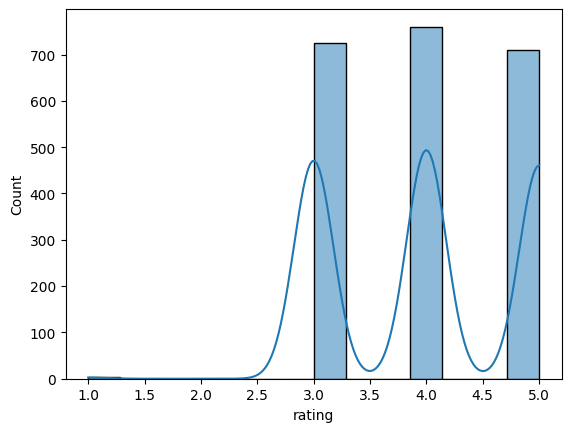

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_triple, x='rating', kde=True)

In [235]:
print(f'Number of ratings:\t{df_triple.shape[0]}')
print(f'Number of movies:\t{df_triple.show_id.nunique()}')
print(f'Number of consumers:\t{df_triple.user_id.nunique()}')
print('Min:\t\t', df_triple['show_id'].value_counts().min())
print('Quartile 1:\t', df_triple['show_id'].value_counts().quantile(.25))
print('Median:\t\t', df_triple['show_id'].value_counts().quantile(.5))
print('Quartile 3:\t', df_triple['show_id'].value_counts().quantile(.75))
print('Max:\t\t', df_triple['show_id'].value_counts().max())
print("\nTriple:\n",df_triple.dtypes)

Number of ratings:	2198
Number of movies:	1832
Number of consumers:	209
Min:		 1
Quartile 1:	 1.0
Median:		 1.0
Quartile 3:	 1.0
Max:		 12

Triple:
 user_id     int64
show_id    object
rating      int64
dtype: object


## Data Preparation


### Cleaning


In [236]:
# Any row with missing value is irrelevant
df_triple = df_triple.dropna()

# use strip in case of any whitespace in show_id strings
df_triple['show_id'] = df_triple['show_id'].str.strip()

# Drop duplicates if applicable
df_triple = df_triple.drop_duplicates()

The keep_list doesn't remove any data because there are only around 200 movies with more than one rating, and we don't want to restrict our model that much.


In [237]:
value_counts = df_triple['show_id'].value_counts()
keep_list = value_counts[value_counts >= 1]

display(keep_list)
df_triple = df_triple.loc[df_triple['show_id'].isin(keep_list.index)]

show_id
s1438    8
s1454    4
s3282    4
s7748    4
s2179    4
        ..
s2469    1
s4920    1
s8395    1
s4203    1
s8443    1
Name: count, Length: 1832, dtype: int64

## Modeling and Evaluation


In [238]:
X, user_mapper, item_mapper, user_inv_mapper, item_inv_mapper = create_matrix(df_triple, 'user_id', 'show_id', 'rating')
print(user_mapper)
print(user_inv_mapper)

{-826756929: 0, -231579545: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 11, 11: 12, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17, 17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25, 25: 26, 26: 27, 27: 28, 28: 29, 29: 30, 30: 31, 31: 32, 32: 33, 33: 34, 34: 35, 35: 36, 36: 37, 37: 38, 38: 39, 39: 40, 40: 41, 41: 42, 42: 43, 43: 44, 44: 45, 45: 46, 46: 47, 47: 48, 48: 49, 49: 50, 50: 51, 51: 52, 52: 53, 53: 54, 54: 55, 55: 56, 56: 57, 57: 58, 58: 59, 59: 60, 60: 61, 61: 62, 62: 63, 63: 64, 64: 65, 65: 66, 66: 67, 67: 68, 68: 69, 69: 70, 70: 71, 71: 72, 72: 73, 73: 74, 74: 75, 75: 76, 76: 77, 77: 78, 78: 79, 79: 80, 80: 81, 81: 82, 82: 83, 83: 84, 84: 85, 85: 86, 86: 87, 87: 88, 88: 89, 89: 90, 90: 91, 91: 92, 92: 93, 93: 94, 94: 95, 95: 96, 96: 97, 97: 98, 98: 99, 99: 100, 100: 101, 101: 102, 102: 103, 103: 104, 104: 105, 105: 106, 106: 107, 107: 108, 108: 109, 109: 110, 110: 111, 111: 112, 112: 113, 113: 114, 114: 115, 115: 116, 116: 117, 117: 118, 118: 119, 119

Provide 10 recommendations for each show. Change k if we want to change the number of recommendations.


### Item Recommendations


In [239]:
k = 10 # number of recommendations per item

df_recommendations = pd.DataFrame(columns=['show_id'], index=item_mapper)
for i in range(1, k + 1):
  df_recommendations[f'Recommendation {i}'] = None

for row in df_recommendations.itertuples():
  rec_ids, rec_distances = recommend(row[0], X, item_mapper, item_inv_mapper, k=k, messages=False)
  df_recommendations.at[row[0], 'show_id'] = row[0]

  for i, r in enumerate(rec_ids):
    df_recommendations.at[row[0], f"Recommendation {i + 1}"] = r

df_recommendations

,show_id,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10
s1004,s1004,s224,s4909,s6358,s1659,s3256,s5883,s4,s8654,s1929,s701
s1005,s1005,s5592,s7434,s4396,s6839,s3570,s7589,s5992,s5111,s5238,s8276
s1006,s1006,s5134,s6054,s2186,s3910,s883,s5116,s8646,s5074,s4516,s2208
s1007,s1007,s5779,s8249,s5341,s5108,s6092,s5858,s2812,s7165,s2933,s8079
s1018,s1018,s1087,s2646,s6111,s478,s6316,s694,s4625,s5744,s193,s4646
...,...,...,...,...,...,...,...,...,...,...,...
s98,s98,s1430,s249,s3041,s7985,s3937,s2995,s4369,s831,s1366,s4488
s985,s985,s1290,s6301,s4599,s6676,s5014,s4014,s7421,s6847,s6218,s5028
s988,s988,s5777,s1966,s990,s5125,s7651,s3993,s1530,s1982,s6138,s6167
s990,s990,s5777,s1966,s988,s5125,s7651,s3993,s1530,s1982,s6138,s6167


#### Azure Deploy


In [240]:
# Connect
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()

# Drop and recreate the table
cursor.execute("DROP TABLE IF EXISTS recommender_collab_item")

cursor.execute("""
CREATE TABLE recommender_collab_item (
    show_id VARCHAR(50),
    rec_1 VARCHAR(50),
    rec_2 VARCHAR(50),
    rec_3 VARCHAR(50),
    rec_4 VARCHAR(50),
    rec_5 VARCHAR(50),
    rec_6 VARCHAR(50),
    rec_7 VARCHAR(50),
    rec_8 VARCHAR(50),
    rec_9 VARCHAR(50),
    rec_10 VARCHAR(50)
)
""")

cursor.fast_executemany = True
cursor.executemany(
    """
    INSERT INTO recommender_collab_item (
        show_id, rec_1, rec_2, rec_3, rec_4,
        rec_5, rec_6, rec_7, rec_8, rec_9, rec_10
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """,
    df_recommendations.values.tolist()
)

# Commit and close
conn.commit()
cursor.close()
conn.close()

print("Upload to Azure SQL completed using raw pyodbc!")

Upload to Azure SQL completed using raw pyodbc!


### User Recommendations


In [241]:
k = 10  # number of recommendations per user
user_ids = df_triple['user_id'].unique()

df_user_recommendations = pd.DataFrame(columns=['user_id'] + [f'Recommendation {i+1}' for i in range(k)])

for user_id in user_ids:
  # Step 1: Find the user's highest rated movies
  df_user_ratings = df_triple[df_triple['user_id'] == user_id]
  if df_user_ratings.empty:
    continue

  max_rating = df_user_ratings['rating'].max()
  df_favorites = df_user_ratings[df_user_ratings['rating'] == max_rating]['show_id']
  
  if df_favorites.empty:
    continue

  # Step 2: Pick one favorite at random
  show_id = df_favorites.sample(n=1).iloc[0]

  # Step 3: Get item-based recommendations
  rec_ids, _ = recommend(show_id, X, item_mapper=item_mapper, item_inv_mapper=item_inv_mapper, k=50, messages=False)

  # Step 4: Filter out seen items
  seen_items = set(df_user_ratings['show_id'])
  filtered_recs = [r for r in rec_ids if r not in seen_items][:k]

  # Step 5: Save to DataFrame
  rec_row = [user_id] + filtered_recs + [None] * (k - len(filtered_recs))  # pad with None if fewer than k
  df_user_recommendations.loc[len(df_user_recommendations)] = rec_row

display(df_user_recommendations)


,user_id,Recommendation 1,Recommendation 2,Recommendation 3,Recommendation 4,Recommendation 5,Recommendation 6,Recommendation 7,Recommendation 8,Recommendation 9,Recommendation 10
0,1,s6177,s6178,s6181,s6079,s6251,s6247,s6245,s6300,s6188,s6298
1,2,s6284,s6290,s6221,s6281,s6239,s628,s6167,s6264,s6254,s6185
2,3,s6284,s6293,s6239,s6290,s6240,s6167,s6264,s628,s6278,s6177
3,4,s6278,s6177,s6195,s6181,s6077,s6247,s6245,s6240,s6298,s6293
4,5,s7289,s2255,s2175,s473,s5,s2038,s1493,s4858,s5028,s1433
...,...,...,...,...,...,...,...,...,...,...,...
204,716841494,s2922,s6375,s1879,s3604,s2519,s6924,s5458,s3022,s8443,s801
205,593251230,s3267,s3082,s775,s5954,s1448,s1753,s5649,s5858,s5857,s6188
206,-826756929,s6284,s8438,s8582,s7498,s1700,s4141,s2874,s3277,s2702,s3267
207,-231579545,s4390,s1157,s5232,s6987,s844,s5389,s6711,s6427,s640,s2254


#### Azure Deploy


In [242]:
# Connect
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()

# Drop and recreate the table
cursor.execute("DROP TABLE IF EXISTS recommender_collab_user")

cursor.execute("""
CREATE TABLE recommender_collab_user (
    user_id VARCHAR(50),
    rec_1 VARCHAR(50),
    rec_2 VARCHAR(50),
    rec_3 VARCHAR(50),
    rec_4 VARCHAR(50),
    rec_5 VARCHAR(50),
    rec_6 VARCHAR(50),
    rec_7 VARCHAR(50),
    rec_8 VARCHAR(50),
    rec_9 VARCHAR(50),
    rec_10 VARCHAR(50)
)
""")

cursor.fast_executemany = True
cursor.executemany(
    """
    INSERT INTO recommender_collab_user (
        user_id, rec_1, rec_2, rec_3, rec_4,
        rec_5, rec_6, rec_7, rec_8, rec_9, rec_10
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """,
    df_user_recommendations.fillna('no_rec').values.tolist() # fillna as a failsafe so the db will still update when less than 10 recs are given to a user
)

# Commit and close
conn.commit()
cursor.close()
conn.close()

print("Upload to Azure SQL completed using raw pyodbc!")

Upload to Azure SQL completed using raw pyodbc!
